<p><img src=".\kayak-logo.png", width=60%, height=60%, align="left"></p>
<h1><center>KAYAK NY & FL Flight Demand Investigation Results</center></h1>
<h3><center>By Sam Rooney</center></h3>

<h3>Preface</h3>
<p>I have been a long time user and admirer of Kayak, the opportunity to explore some sample data has been a truely enjoyable experience. Given more time there are a multitude of things I would continue to explore, analyze and predict for this investigation. I appreciate this opportunity and I hope you enjoy this analysis.</p>

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from kayak_tools import DataPrepr, PredictNextMonth
from sklearn.linear_model import Ridge
from fbprophet import Prophet
import datetime as dt
import eli5
import pandas as pd
import numpy as np

df = pd.read_csv('NY_FL_flight_demand.csv', parse_dates=['search_date'])
df.head()

/usr/local/lib/python3.5/dist-packages/eli5/base_utils.py:23: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  init_args = inspect.getargspec(class_.__init__)


,search_date,origin_airport_code,origin_city,origin_region,origin_country,dest_airport_code,destination_city,destination_region,destination_country,flight_demand
0,2016-06-05,ECP,Panama City,FL,US,DEN,Denver,CO,US,135
1,2016-06-05,MIA,Miami,FL,US,BOS,Boston,MA,US,3909
2,2016-06-05,PGD,Punta Gorda,FL,US,JFK,New York,NY,US,15
3,2016-06-05,JAX,Jacksonville,FL,US,WAS,Washington,DC,US,943
4,2016-06-05,EYW,Key West,FL,US,CLT,Charlotte,NC,US,67


In [2]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694917 entries, 0 to 694916
Data columns (total 10 columns):
search_date            694917 non-null datetime64[ns]
origin_airport_code    694917 non-null object
origin_city            694917 non-null object
origin_region          694917 non-null object
origin_country         694917 non-null object
dest_airport_code      694917 non-null object
destination_city       694917 non-null object
destination_region     694917 non-null object
destination_country    694917 non-null object
flight_demand          694917 non-null int64
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 53.0+ MB


(None,        flight_demand
 count  694917.000000
 mean     1159.990747
 std      3445.337103
 min         7.000000
 25%        46.000000
 50%       183.000000
 75%       880.000000
 max    188365.000000)

In [3]:
df.search_date.min(), df.search_date.max()

(Timestamp('2016-03-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [4]:
df.isnull().values.any()

False

In [5]:
# Add temporal features to our dataset
df['day_of_week'] = df['search_date'].dt.weekday_name
df['week_number'] = df['search_date'].dt.week
df['month'] = df['search_date'].dt.month
df['year'] = df['search_date'].dt.year

In [6]:
#Add log of flight demand and drop rows that contain numbers in airport codes
#log will help make time series stationary
df['log_flight_demand'] = np.log(df['flight_demand'])
df.drop(df[df['origin_airport_code'].str.contains(r'\w*\d\w*')].index, inplace=True)

<h3>EDA</h3>

/home/srooney/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


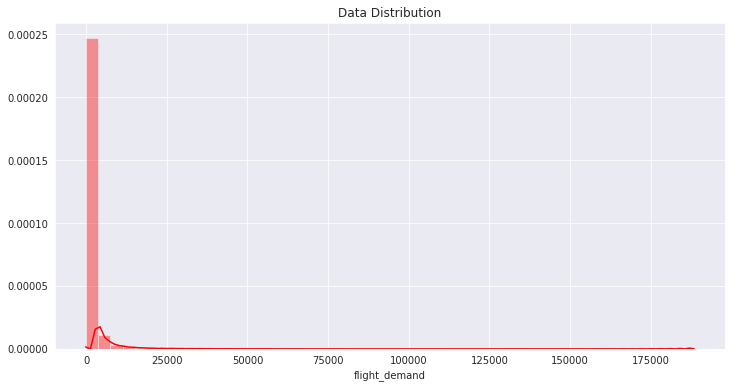

In [7]:
%matplotlib inline

#plot the distribution of the data
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
plt.title('Data Distribution')
sns.distplot(df['flight_demand'], color="r")
plt.show()

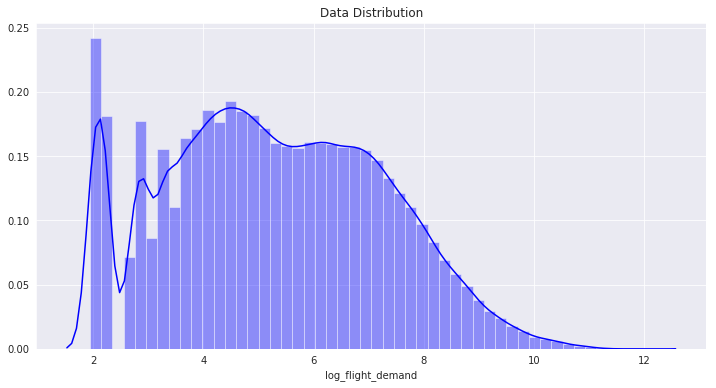

In [8]:
#take the log of our data and look at the distribution again.
plt.figure(figsize=(12,6))
sns.distplot(df['log_flight_demand'], color="b")
plt.title('Data Distribution')
plt.show()

<h3>Our distribution is skewed and has a long tail.</h3>

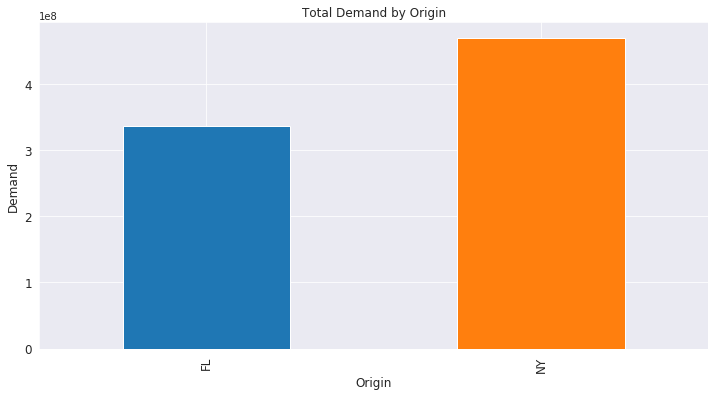

In [9]:
origin_totals = df.groupby(['origin_region']).sum()

ax = origin_totals['flight_demand'].plot(kind='bar', title ="Total Demand by Origin", figsize=(12, 6),fontsize=12)
ax.set_xlabel("Origin", fontsize=12)
ax.set_ylabel("Demand", fontsize=12)
plt.show()

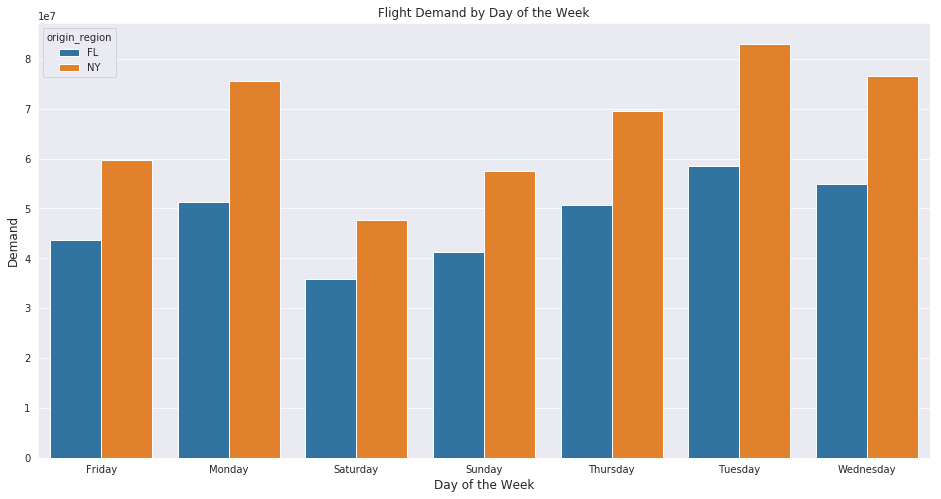

In [10]:
origin_totals = pd.DataFrame(df.groupby(['origin_region', 'day_of_week'])['flight_demand'].sum()).reset_index()
plt.figure(figsize=(16,8))
ax = sns.barplot(x="day_of_week", y="flight_demand",hue="origin_region", data=origin_totals)
ax.set_xlabel("Day of the Week", fontsize=12)
ax.set_ylabel("Demand", fontsize=12)
plt.title('Flight Demand by Day of the Week')
plt.show()

<h3>Tuesday is the most popular day for users in both FL and NY to search for flights.</h3>

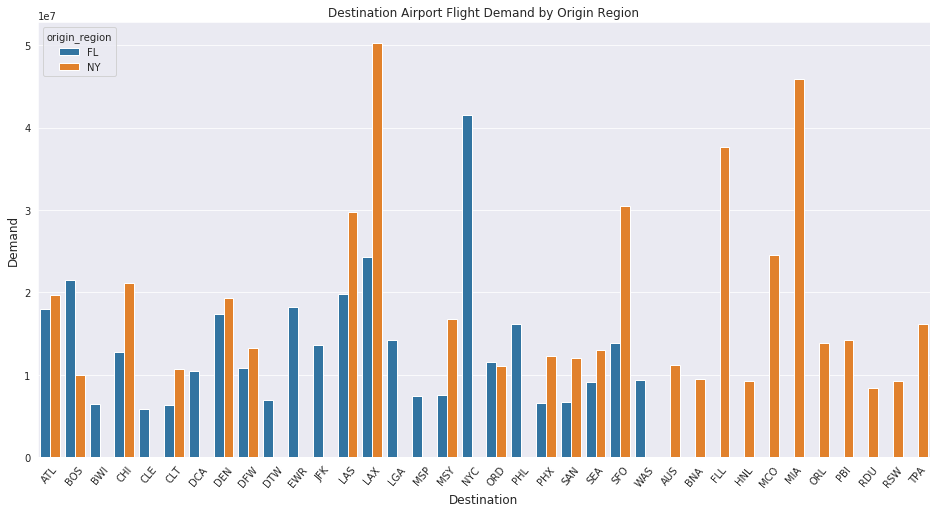

In [11]:
dest_counts = df.groupby(['origin_region','dest_airport_code']).sum().reset_index()

plt.figure(figsize=(16,8))
ax = sns.barplot(x="dest_airport_code", y="flight_demand", hue="origin_region", data=dest_counts)
ax.set_xlabel("Destination", fontsize=12)
ax.set_ylabel("Demand", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
plt.title('Destination Airport Flight Demand by Origin Region')
plt.show()

1. Do you see any interesting patterns in the data? For example, are there any seasonality
trends in demand? Do these seasonality trends differ between flights departing from
New York state (origin_region = NY) vs Florida (origin_region = FL)? Can you think of
any potential explanations for the patterns, trends, or differences you observed?

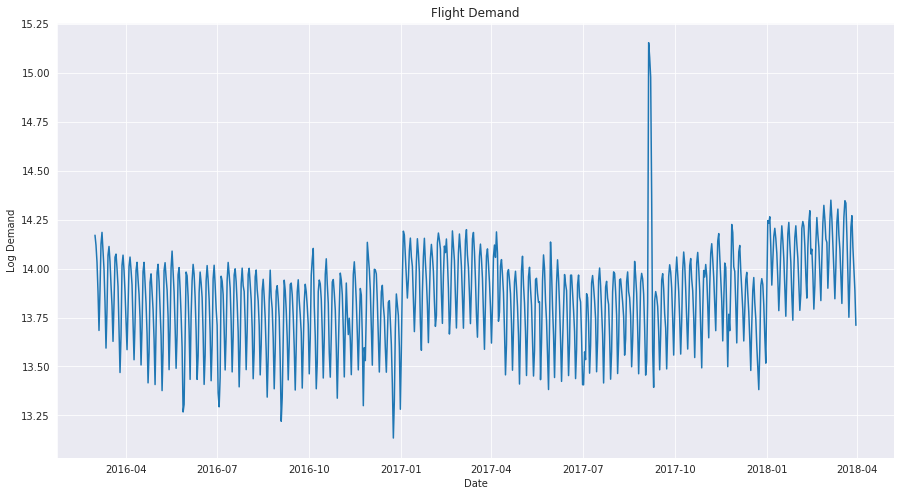

In [12]:
df.sort_values('search_date')
by_day_df = df.groupby(['search_date']).sum()
by_day_df['log_flight_demand'] = np.log(by_day_df['flight_demand'])
sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
plt.title('Flight Demand')
plt.xlabel('Date')
plt.ylabel('Log Demand')
plt.plot(by_day_df['log_flight_demand'])
plt.show()

<h3><p>To gauge whether there is seasonality in our data it will be a valuable task to break down our time series data into systematic and unsystematic components.</p>
<p>
The systematic components of the time series are components that reoccur or have some variation of consistency that can be modeled. The non-systematic components are those that cannot be directly modeled.</p>
<p>    
A usual time series dataset in theory should commonly have three predominant components which are; <br />
    level - average in series.<br />
    trend - are the values in the series going up or down.<br /> 
    seasonality - cyclic or repeating trends in the data. <br />
</p>
<p>    
There are other components like noise which is observed random variation that is non-systematic.
We will use a self proclaimed nieve approach to investigate this, statsmodels seasonal decomposition, which states;
"This is a nieve decomposition. More sophisticated methods should be preferred.". This seasonal decomposition uses moving averages.</p>
<p>
The additive model is: Y[t] = T[t] + S[t] + e[t]<br />
The multiplicative model is: Y[t] = T[t] * S[t] * e[t]
   </p>
<p>Given more time on this I'd probably look at other decomposition methods (like Fourier) to confirm and identify any other interactions that this method is failing to find.<p></h3>

<Figure size 432x288 with 0 Axes>

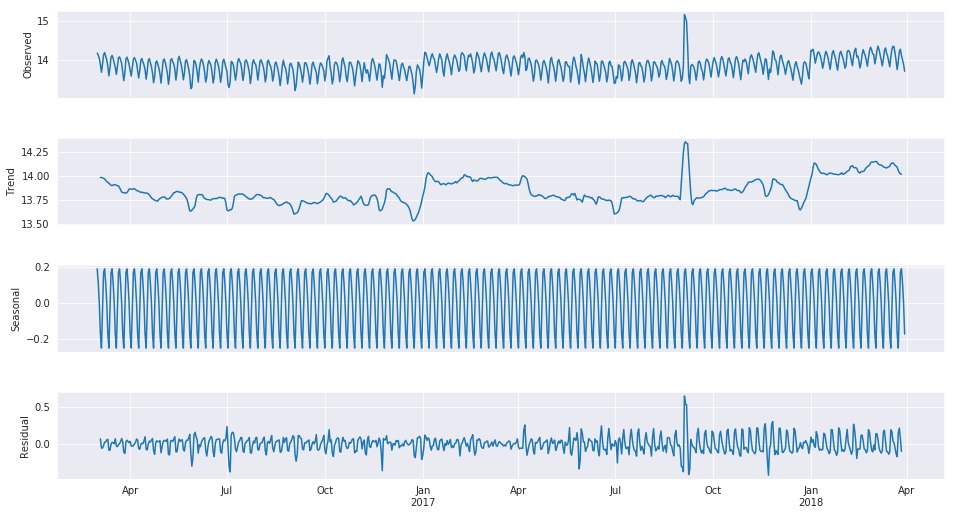

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

by_day_df = by_day_df['log_flight_demand']
by_day_df.index = pd.DatetimeIndex(freq='d', start=by_day_df.index.min(), periods=len(by_day_df))
decomposition = seasonal_decompose(by_day_df)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

<h3><p>We can see by this initial daily aggregation that there appears to be seasonality in this data, having a frequent cyclic seasonality. There's also yearly trends which of the most prominant is the period coming into January, where demand significantly increases and is sustained until the end of March/early April. We can also see a large spike around 2017-9 which is significant.</p>
<br/>
Now let's split the data and inspect the daily aggregated trends for each origin region over the data range.
</h3>


In [14]:
ny_by_day_df = df.loc[df['origin_region'] == 'NY'].groupby(['search_date']).sum()
ny_by_day_df['log_d'] = np.log(ny_by_day_df['flight_demand'])
ny_by_day_df = ny_by_day_df[['flight_demand', 'log_d']]
ny_by_day_df.index = pd.DatetimeIndex(freq='d', start=ny_by_day_df.index.min(), periods=len(ny_by_day_df))

fl_by_day_df = df.loc[df['origin_region'] == 'FL'].groupby(['search_date']).sum()
fl_by_day_df['log_d'] = np.log(fl_by_day_df['flight_demand'])
fl_by_day_df = fl_by_day_df[['flight_demand', 'log_d']]
fl_by_day_df.index = pd.DatetimeIndex(freq='d', start=fl_by_day_df.index.min(), periods=len(fl_by_day_df))

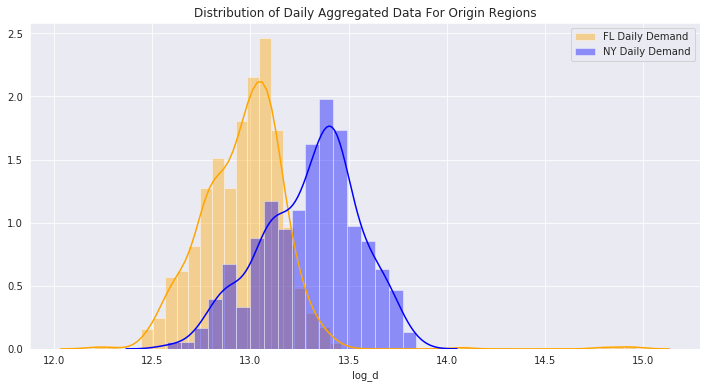

In [15]:
plt.figure(figsize=(12,6))
sns.distplot(fl_by_day_df['log_d'], color="orange", label='FL Daily Demand')
sns.distplot(ny_by_day_df['log_d'], color="b", label='NY Daily Demand')
plt.title('Distribution of Daily Aggregated Data For Origin Regions')
plt.legend()
plt.show()

<h3>FL distribution has a long tail (more than likely the peak we witnessed).</h3>

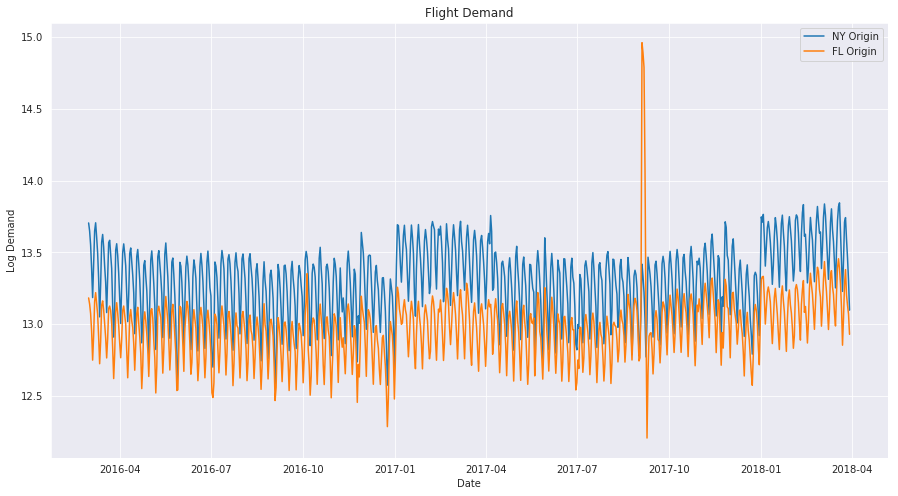

In [16]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
plt.title('Flight Demand')
plt.xlabel('Date')
plt.ylabel('Log Demand')
plt.plot(ny_by_day_df['log_d'], label='NY Origin')
plt.plot(fl_by_day_df['log_d'], label='FL Origin')
plt.legend()
plt.show()

<h3>This plot is a little difficult to look at, but shows similarities in the two series. We can improve this view by determining and plotting the trend of each origins time series.</h3>

<Figure size 432x288 with 0 Axes>

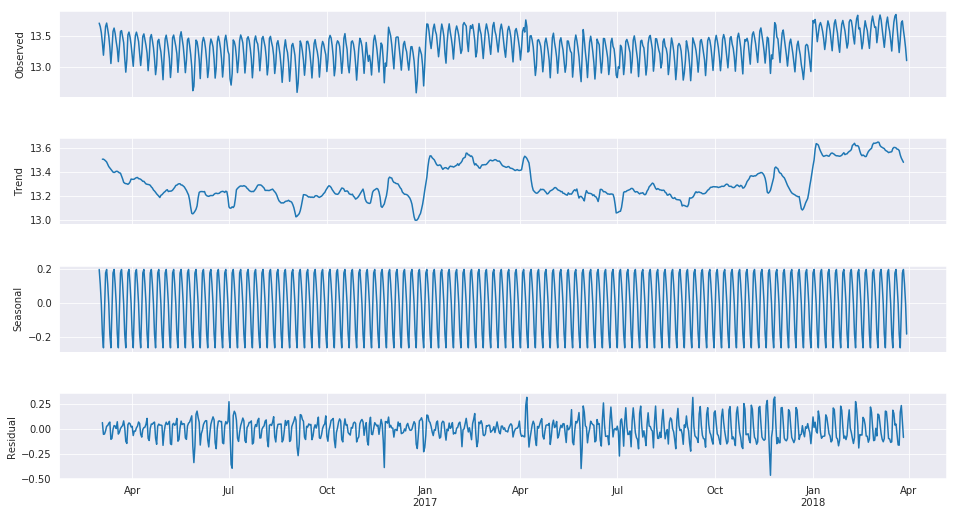

In [17]:
decomposition = seasonal_decompose(ny_by_day_df['log_d'])
ny_by_day_df['trend'] = decomposition.trend
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

<h3>NY data exhibits pretty distinct trends. We see that the patterns for 2016, 2017 and 2018 are all very similar but with and increasing trend as time goes on.</h3>

<Figure size 432x288 with 0 Axes>

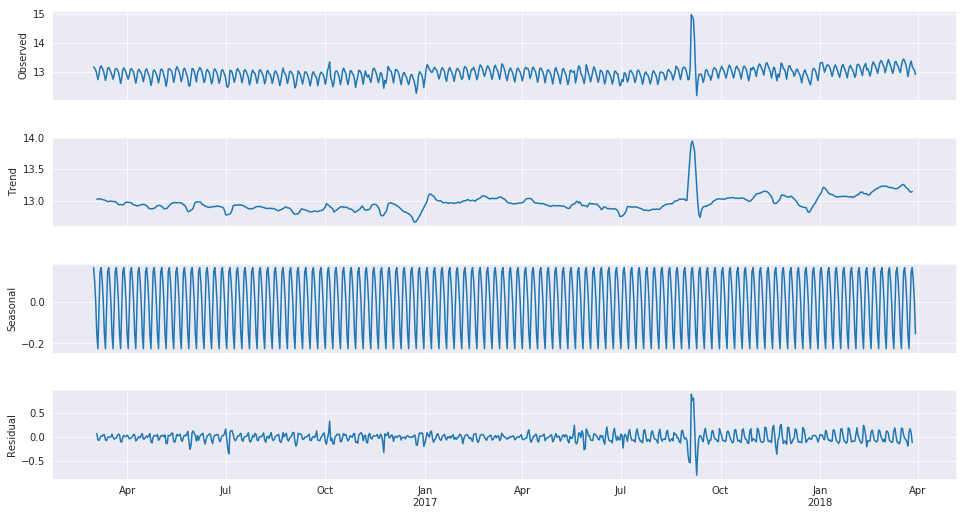

In [18]:
decomposition = seasonal_decompose(fl_by_day_df['log_d'])
fl_by_day_df['trend'] = decomposition.trend
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

<h3>FL data shows similar trends to the NY data. There is one big abnormality here though, this big spike in 2017-9, now there could be any number of reasons why we're seeing this, which might include:
<ol>
<li>A data or system error.</li>
<li>A significant targeted campaign for FL travellers.</li>
<li>A significant natural disaster that people were trying to avoid or required evacuation.</li>
<li>etc.</li>
</ol>
</h3>

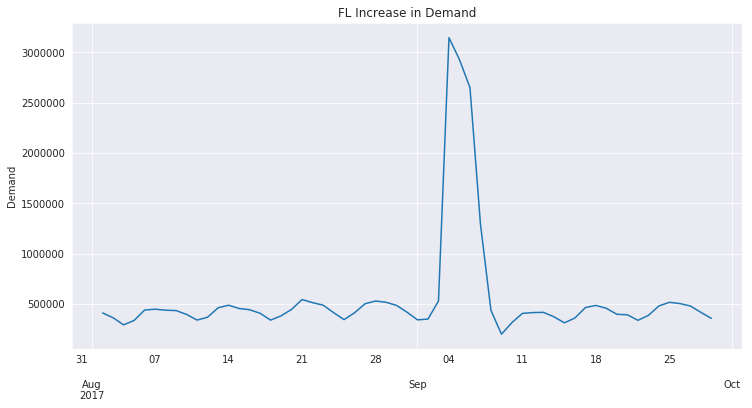

In [ ]:
start = dt.datetime.strptime('2017-08-01', '%Y-%m-%d')
end = dt.datetime.strptime('2017-09-30', '%Y-%m-%d')
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
fl_by_day_df['flight_demand'].loc[(fl_by_day_df.index > start) & (fl_by_day_df.index < end)].plot()
plt.title('FL Increase in Demand')
plt.ylabel('Demand')
plt.show()

<h3>We see the peak being of the week leading up to hurricane Irma. Our date being search date we can justify that that due to the circumstances the drastic spike in demand was probably by Florida locals and travellers looking to get out before the hurricane hit.</h3>

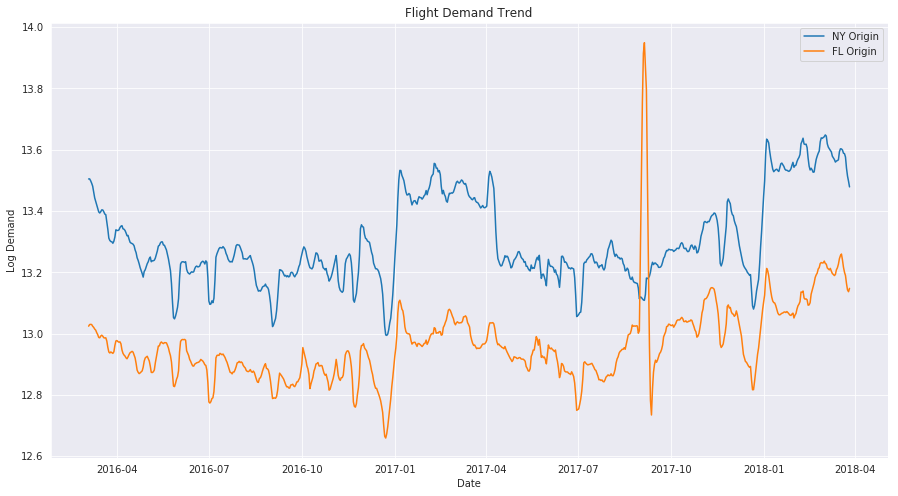

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
plt.title('Flight Demand Trend')
plt.xlabel('Date')
plt.ylabel('Log Demand')
plt.plot(ny_by_day_df['trend'], label='NY Origin')
plt.plot(fl_by_day_df['trend'], label='FL Origin')
plt.legend()
plt.show()

<h3>Plotting the trends for both of our origin regions we see there is a lot of similarity between them. NY overall has a higher demand, but both origins share very similar demand patterns (despite the previously discussed spike in the FL data).</h3>
<h3>Now let's look at the weekly demand for different destinations for each of our origins to see where the users are searching at what times of the year.</h3>

2. What kinds of differences do you observe in popular destinations for flights from FL vs
popular destinations for flights from NY? What are potential explanations for these
differences?

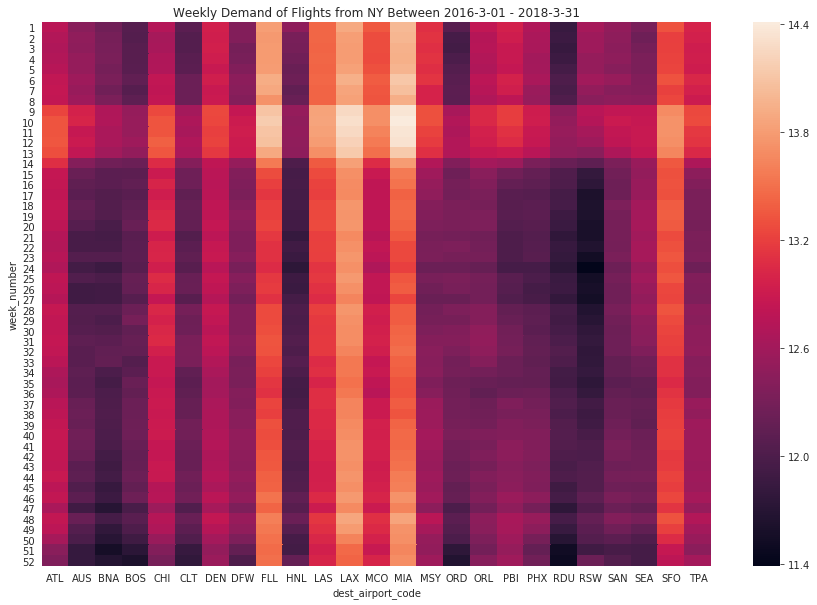

In [ ]:
ny_week = df.loc[df['origin_region']=='NY'].groupby(['dest_airport_code','week_number']).sum()
ny_week['log_flight_demand'] = np.log(ny_week['flight_demand'])
ny_week = ny_week.drop(['year','month'], axis = 1)
ny_week = ny_week.pivot_table(values='log_flight_demand', index='week_number', columns='dest_airport_code', fill_value=0)

plt.figure(figsize=(15,10))
ax = sns.heatmap(ny_week )
ax.set_title('Weekly Demand of Flights from NY Between 2016-3-01 - 2018-3-31')
plt.yticks(rotation=0)
plt.show()

<h3>With this view we can see that LAX, MIA, FLL and SFO are popular destinations for NY'ers to book throughout the year. We can see that weeks 9 - 13 are the most popular for booking, not just the aforemention destinations but all destinations that users were looking to book for at that time. This increase could be for spring break, upcoming summer holidays and holiday weekends etc.</h3>

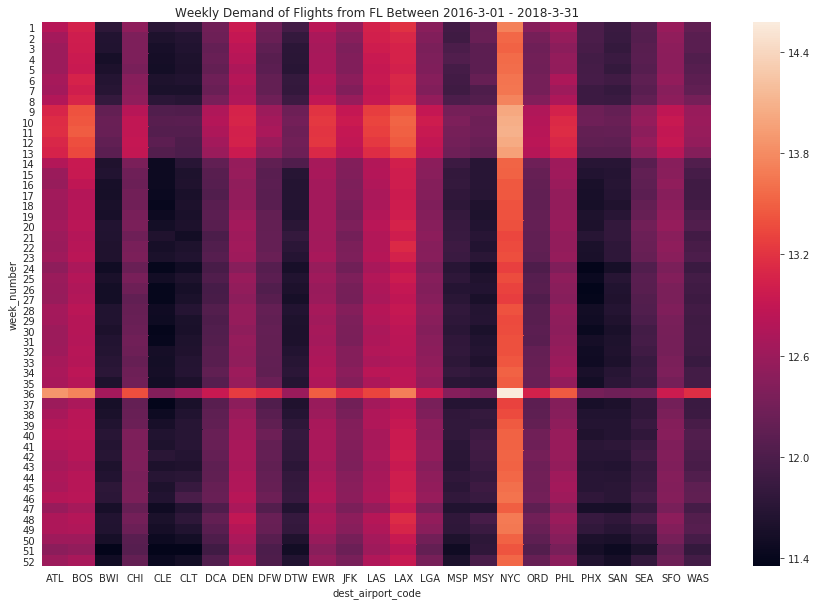

In [ ]:
fl_week = df.loc[df['origin_region']=='FL'].groupby(['dest_airport_code','week_number']).sum()
fl_week['log_flight_demand'] = np.log(fl_week['flight_demand'])
fl_week = fl_week.drop(['year','month'], axis = 1)
fl_week = fl_week.pivot_table(values='log_flight_demand', index='week_number', columns='dest_airport_code', fill_value=0)

plt.figure(figsize=(15,10))
ax = sns.heatmap(fl_week)
ax.set_title('Weekly Demand of Flights from FL Between 2016-3-01 - 2018-3-31')
plt.yticks(rotation=0)
plt.show()

<h3>Again we observe the busy search period weeks 9-13 and the spike at week 36 was more than likely due to the Hurricane Irma that hit Florida in 2017. We see a lot of the popular destinations are east located which might suggest that searchers from FL are aware of and influx of holiday makers looking to decend there (the demand for FL flights from NY) and are trying to avoid the crowds in their home state.</h3>

In [ ]:
dest_st = df.groupby(['origin_region', 'destination_region'], as_index=False)['flight_demand'].sum()
dest_st['rank_'] = dest_st.groupby(by=['origin_region'])['flight_demand'].rank(ascending=False)
dest_st = dest_st.pivot_table(values=['destination_region','flight_demand', 'rank_'], index='destination_region', columns=['origin_region'], fill_value=0).reset_index()
dest_st.sort_values(['destination_region'], inplace=True)
dest_st

destination_region flight_demand            rank_    
origin_region                               FL         NY    FL  NY
0                             AZ       6562619   12247326    16  11
1                             CA      44870541   92773333     2   2
2                             CO      17398419   19343389     9   7
3                             DC      19839431          0     5   0
4                             FL             0  161597405     0   1
5                             GA      18045622   19665064     8   6
6                             HI             0    9281803     0  14
7                             IL      24289388   32266311     3   3
8                             LA       7522700   16724553    13   9
9                             MA      21514965   10033857     4  12
10                            MD       6438520          0    17   0
11                            MI       7006212          0    15   0
12                            MN       7421931          0    14   0
13                            NC       6364108   19056601    18   8
14                            NJ      18247121          0     7   0
15                            NV      19751862   29748746     6   4
16                            NY      69342027          0     1   0
17                            OH       5823535          0    19   0
18                            PA      16130699          0    10   0
19                            TN             0    9487619     0  13
20                            TX      10777492   24466059    11   5
21                            WA       9077105   12980473    12  10

<h3>The top destination state for NY based searchers was FL, and NY for FL users. Both states then had CA in second place and IL in third. NV, CO and GA were also in the top 10 of both (popular travel destinations). FL users had a lot of interest in flying to the NE region of the country having NYC, MA, NJ and PA all in the top 10 states from FL.</h3>

In [ ]:
df2 = df.groupby(['origin_region', 'destination_region', 'dest_airport_code'], as_index=False)['flight_demand'].sum()
df2 = pd.DataFrame(df2)
df2 = df2.sort_values(['origin_region', 'flight_demand'], ascending=False).reset_index(drop=True)
df2['rank_'] = df2.groupby(by=['origin_region'])['flight_demand'].rank(ascending=False)
d3 = df2.pivot_table(values=['destination_region','dest_airport_code','flight_demand', 'rank_'], index=['destination_region','dest_airport_code'], columns=['origin_region'], fill_value=0).reset_index()
d3.sort_values(['destination_region'], inplace=True)
d3

destination_region dest_airport_code flight_demand            \
origin_region                                                 FL        NY   
0                             AZ               PHX       6562619  12247326   
1                             CA               LAX      24319425  50238008   
2                             CA               SAN       6713293  12020669   
3                             CA               SFO      13837823  30514656   
4                             CO               DEN      17398419  19343389   
5                             DC               DCA      10502292         0   
6                             DC               WAS       9337139         0   
7                             FL               FLL             0  37638721   
8                             FL               MCO             0  24567688   
9                             FL               MIA             0  45930943   
10                            FL               ORL             0  13838696   
11                            FL               PBI             0  14237521   
12                            FL               RSW             0   9233485   
13                            FL               TPA             0  16150351   
14                            GA               ATL      18045622  19665064   
15                            HI               HNL             0   9281803   
17                            IL               ORD      11514591  11087231   
16                            IL               CHI      12774797  21179080   
18                            LA               MSY       7522700  16724553   
19                            MA               BOS      21514965  10033857   
20                            MD               BWI       6438520         0   
21                            MI               DTW       7006212         0   
22                            MN               MSP       7421931         0   
23                            NC               CLT       6364108  10674345   
24                            NC               RDU             0   8382256   
25                            NJ               EWR      18247121         0   
26                            NV               LAS      19751862  29748746   
27                            NY               JFK      13665437         0   
28                            NY               LGA      14173611         0   
29                            NY               NYC      41502979         0   
30                            OH               CLE       5823535         0   
31                            PA               PHL      16130699         0   
32                            TN               BNA             0   9487619   
34                            TX               DFW      10777492  13315155   
33                            TX               AUS             0  11150904   
35                            WA               SEA       9077105  12980473   

              rank_      
origin_region    FL  NY  
0                22  16  
1                 2   1  
2                21  17  
3                10   4  
4                 7   9  
5                15   0  
6                16   0  
7                 0   3  
8                 0   6  
9                 0   2  
10                0  13  
11                0  12  
12                0  24  
13                0  11  
14                6   8  
15                0  23  
17               13  19  
16               12   7  
18               18  10  
19                3  21  
20               23   0  
21               20   0  
22               19   0  
23               24  20  
24                0  25  
25                5   0  
26                4   5  
27               11   0  
28                9   0  
29                1   0  
30               25   0  
31                8   0  
32                0  22  
34               14  14  
33                0  18  
35               17  15

4. The dataset contains data until March 31, 2018. Can you predict or forecast the total
monthly demand for each origin+destination route pair in the dataset for April 2018?
What did you do to increase the robustness of your predictions? What do you think are
challenges to predictive accuracy (even if you do not have time to address them)?

<h3>
Now for modeling and predicting the demand of flights there are a number of considerations
for this investigation I will explore 2 methods:
<ol><br />
<li>A ML approach that uses binary time indexes as features (year, week, day of the week) and origin/destination information to make predictions.</li><br />
<li>Univariate time series predictions for given flight routes.</li></ol>

<h3><p>For the first approach I will test 2 models (linear regression using L2 regularization (ridge) and a random forests regressor) and a more ML focused strategy to try and predict the demand for April 2018. I will start off by preparing the data, turning time indexes into binary variables along with all of our other contextual data (origins destinations). At this step there is the opportunity to perform feature engineering, but due to the time constraints instead of enriching the data with these I will discuss them in the last section.</p>
<p>
To speed these up I have developed some very simple data processing classes (bare minimum but helpful for this task).</p></h3>

In [ ]:
data = DataPrepr(data = './NY_FL_flight_demand.csv')
data.prepare()

In [ ]:
d = data.df
d = d.sort_values(['search_date']).reset_index(drop=True)
start = dt.datetime.strptime('2018-01-31', '%Y-%m-%d') #'2017-10-31'
X_train, X_test = d.loc[d['search_date'] <= start].drop(['flight_demand', 'search_date', 'month'], axis = 1), d.loc[d['search_date'] > start].drop(['flight_demand', 'search_date', 'month'], axis = 1)
y_train, y_test = d.loc[d['search_date'] <= start]['flight_demand'], d.loc[d['search_date'] > start]['flight_demand']

<h3>Because we are using a linear model and essentially time based data we are going to take the log of our target variable which should inherently increase the performance of our model.<h3>

In [ ]:
d['lg_flight_demand'] = np.log(d['flight_demand'])
y_train_lg, y_test_lg = d.loc[d['search_date'] <= start]['lg_flight_demand'], d.loc[d['search_date'] > start]['lg_flight_demand']

<h3><p>A quick grid search to look for an ideal alpha value. Ideally we'd want to do a far more robust hyperparameter optiimization search and CV that preserves the time series order but still allows for decent CV to be ran, such as sklearns TimeSeriesSplit so that we could determine the best alpha value to ensure no over/underfitting and model robustness.
</p>
<p>
TRAIN: [0] TEST: [1]<br />
TRAIN: [0 1] TEST: [2]<br />
TRAIN: [0 1 2] TEST: [3]<br />
TRAIN: [0 1 2 3] TEST: [4]<br />
TRAIN: [0 1 2 3 4] TEST: [5]<br />
    </p>
</h3>

In [ ]:
# 5 or 10 CVs would be ideal but will just go with the default 3.
params = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}

# create and fit a ridge regression model, testing random alpha values
ridge = Ridge()
rsearch = GridSearchCV(ridge, params, verbose=2)
rsearch.fit(X_train, y_train_lg)
print(rsearch)

# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] alpha=1 .........................................................
[CV] .......................................... alpha=1, total=   9.2s
[CV] alpha=1 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s


[CV] .......................................... alpha=1, total=   8.3s
[CV] alpha=1 .........................................................
[CV] .......................................... alpha=1, total=   8.1s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   7.9s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   7.9s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   7.8s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   7.8s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   7.8s
[CV] alpha=0.01 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)
0.8861004168514749
0.0001


In [ ]:
rr = Ridge(alpha=rsearch.best_estimator_.alpha)
rr.fit(X_train, y_train_lg)
print("Train-set R^2: {:.2f}".format(rr.score(X_train, y_train_lg)))
print("Test-set R^2: {:.2f}".format(rr.score(X_test, y_test_lg)))
y_pred = rr.predict(X_test)
y_pred_train = rr.predict(X_train)

Train-set R^2: 0.89
Test-set R^2: 0.89


<h3>For ease of analysis for the purpose of this exercise some of the results are going to be aggregated. This will lose some information (route specifics etc.) but will be able to give a decent understanding of how the model performs overall.</h3>

/home/srooney/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


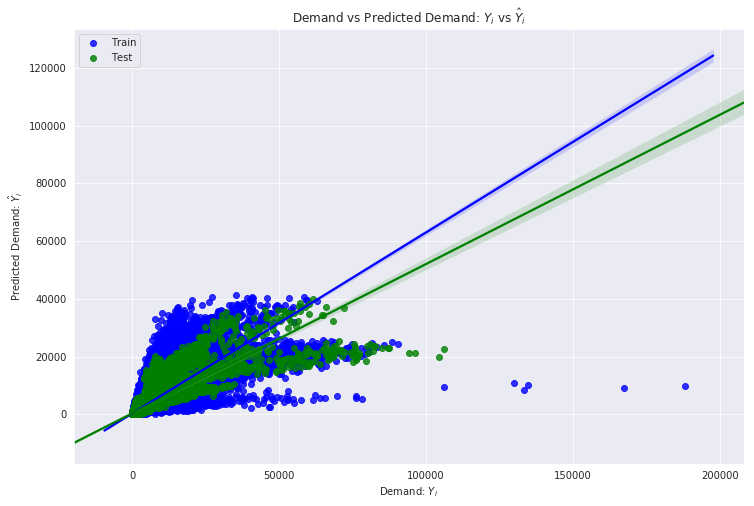

In [ ]:
viz_y_train = d.loc[d['search_date'] <= start][['search_date', 'lg_flight_demand', 'flight_demand']]
viz_y_test = d.loc[d['search_date'] > start][['search_date', 'lg_flight_demand', 'flight_demand']]
viz_y_train['y_pred'] = y_pred_train
viz_y_train['y_pred_n'] = np.exp(viz_y_train['y_pred'])
viz_y_test['y_pred'] = y_pred
viz_y_test['y_pred_n'] = np.exp(viz_y_test['y_pred'])
y_test_gbd = viz_y_test.groupby('search_date').sum()
y_train_gbd = viz_y_train.groupby('search_date').sum()

plt.figure(figsize=(12,8))
# ax = sns.regplot(viz_y_test['flight_demand'], viz_y_test['y_pred_n'])
ax = sns.regplot(viz_y_train['flight_demand'], viz_y_train['y_pred_n'], label='Train', color="b")
ax = sns.regplot(viz_y_test['flight_demand'], viz_y_test['y_pred_n'], label='Test', color="g")
plt.xlabel("Demand: $Y_i$")
plt.ylabel("Predicted Demand: $\hat{Y}_i$")
plt.title("Demand vs Predicted Demand: $Y_i$ vs $\hat{Y}_i$")
plt.legend()
plt.show()

<h3>Not a great looking distribution here, we see the predictions of higher values really struggles which suggests that our linear model probably failed to pick up crucial relationships/concepts in the data. We do see that the test set was pretty skewed.</h3>

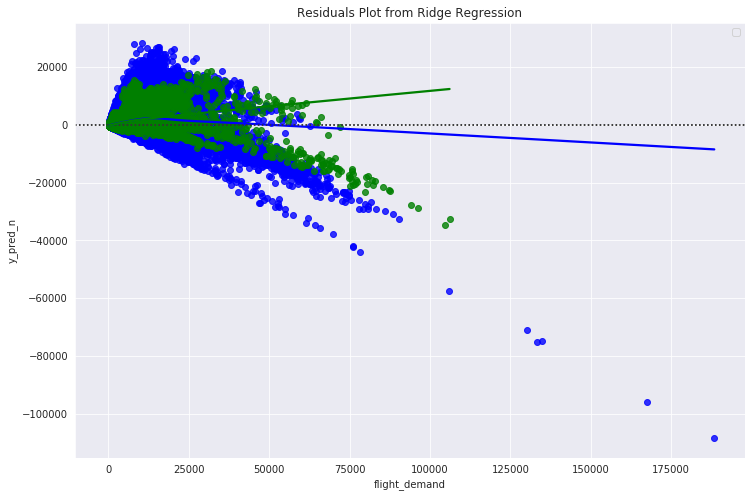

In [ ]:
plt.figure(figsize=(12,8))
sns.residplot(viz_y_train['flight_demand'], viz_y_train['y_pred_n'], lowess=True, color="b")
sns.residplot(viz_y_test['flight_demand'], viz_y_test['y_pred_n'], lowess=True, color="g")
plt.title('Residuals Plot from Ridge Regression')
plt.legend()
plt.show()

<h3>Residuals plot doesn't show any strong sings of homodasdicity which is good.</h3>

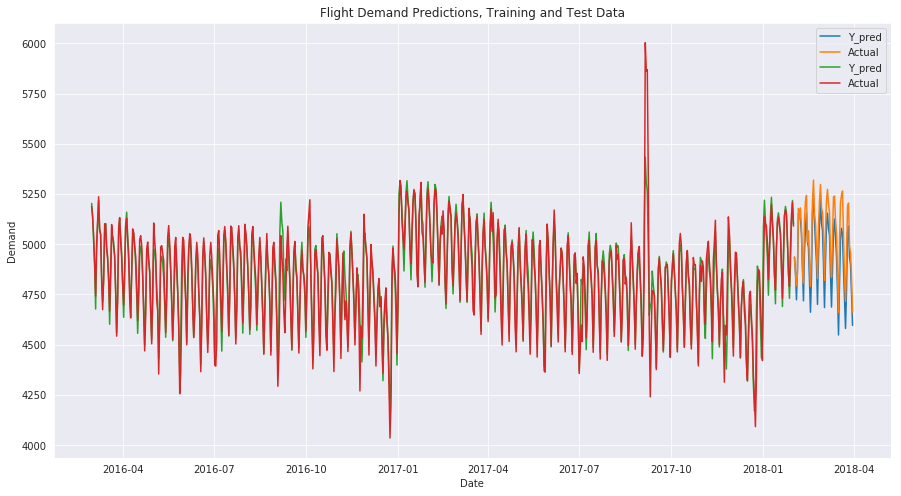

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
plt.title('Flight Demand Predictions, Training and Test Data')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.plot(y_test_gbd.index, y_test_gbd['y_pred'], label='Y_pred')
plt.plot(y_test_gbd.index, y_test_gbd['lg_flight_demand'], label='Actual')
plt.plot(y_train_gbd.index, y_train_gbd['y_pred'], label='Y_pred')
plt.plot(y_train_gbd.index, y_train_gbd['lg_flight_demand'], label='Actual')
plt.legend()
plt.show()

<h3>When plotting in log our results look pretty good. The model fits both the test and training data pretty well, but under fits a little on the test set.</h3>

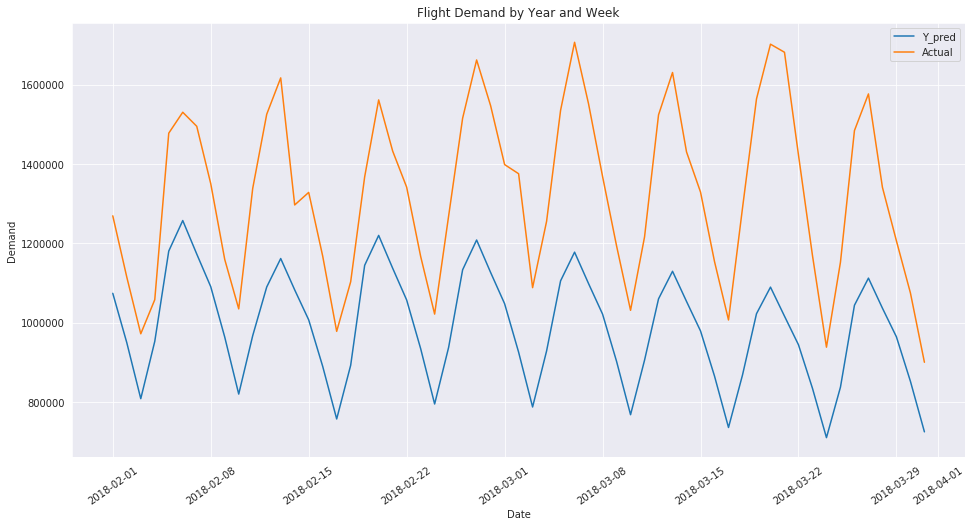

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,8))
plt.title('Flight Demand by Year and Week')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.plot(y_test_gbd.index, y_test_gbd['y_pred_n'], label='Y_pred')
plt.plot(y_test_gbd.index, y_test_gbd['flight_demand'], label='Actual')
plt.xticks(rotation=35)
plt.legend()
plt.show()

<h3>When plotting back in real values and comparing the test outcome we can see it under predicted, but this is to be expected considering the lack of information and tuning.</h3>

In [ ]:
print('Test RMSE: ',((y_test_gbd['y_pred_n']- y_test_gbd['flight_demand']) ** 2).mean() ** .5)

Test RMSE:  352493.346643479


In [ ]:
eli5.show_weights(rr, feature_names=list(X_train))

Weight?,Feature
+5.004,origin_airport_code_NYC
+4.768,origin_airport_code_MIA
+4.321,origin_airport_code_FLL
+3.979,origin_airport_code_TPA
+3.666,origin_airport_code_JFK
+3.304,origin_airport_code_JAX
+3.102,origin_airport_code_MCO
+2.902,origin_airport_code_LGA
+2.858,origin_airport_code_PBI
+2.776,<BIAS>


<h3>Taking a look at the feature weights from our model we see that the two most popular origin aiports have the highest weights, which of course makes sense given that demand is higher at these airports. To improve this linear model we could:
<ol>
<li>Get more data.</li>
<li>Preprocess the data PolynomialFeatures transformation with interation_only=True would be the starting point so the model could learn the date interations and determine a coefficient for each combination of day-week-year. </li>
<li>Feature engineering, add features starting with t-n values (would vet for collinearity), try including month as a dummy vaiable over week number.</li>
<li>Try L1 regularization in an attempt to reduce shrink the weights of insignificat features that might be adding noise.</li>
<li>Do a more comprehensive hyperparameter search, using RandomSearch for eg. and more CV folds.</li>
<li>Try some different sampling methodologies to try to preserve similar distributions between test and train sets.</li>
</h3>

In [ ]:
RFR = RandomForestRegressor(n_estimators=300, min_samples_split=5, 
                            min_samples_leaf=1, max_features='sqrt', 
                            max_depth=50, bootstrap=False)
RFR.fit(X_train, y_train)
print("Train-set R^2: {:.2f}".format(RFR.score(X_train, y_train)))
print("Test-set R^2: {:.2f}".format(RFR.score(X_test, y_test)))
rf_y_pred = RFR.predict(X_test)
rf_y_pred_train = RFR.predict(X_train)

In [ ]:
rf_viz_y_train = d.loc[d['search_date'] <= start][['search_date', 'lg_flight_demand', 'flight_demand']]
rf_viz_y_test = d.loc[d['search_date'] > start][['search_date', 'lg_flight_demand', 'flight_demand']]
rf_viz_y_train['y_pred'] = rf_y_pred_train
rf_viz_y_test['y_pred'] = rf_y_pred
rf_y_test_gbd = rf_viz_y_test.groupby('search_date').sum()
rf_y_train_gbd = rf_viz_y_train.groupby('search_date').sum()

plt.figure(figsize=(10, 10))
#ax = sns.regplot(rf_y_test_gbd['flight_demand'], rf_y_test_gbd['y_pred'])
ax = sns.regplot(rf_viz_y_train['flight_demand'], rf_viz_y_train['y_pred'], label='Train', color="b")
ax = sns.regplot(rf_viz_y_test['flight_demand'], rf_viz_y_test['y_pred'], label='Test', color="g")
plt.xlabel("Demand: $Y_i$")
plt.ylabel("Predicted Demand: $\hat{Y}_i$")
plt.title("Demand vs Predicted Demand: $Y_i$ vs $\hat{Y}_i$")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sns.residplot(rf_viz_y_train['flight_demand'], rf_viz_y_train['y_pred'], lowess=True, color="b", label='Train')
sns.residplot(rf_viz_y_test['flight_demand'], rf_viz_y_test['y_pred'], lowess=True, color="g", label='Test')
plt.title('Residuals Plot from Random Forests')
plt.legend()
plt.show()

<h3>Our test data had a pretty long tail but our model did a decent job.</h3> 

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,8))
plt.title('Flight Demand Predictions')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.plot(rf_y_test_gbd.index, rf_y_test_gbd['y_pred'], label='Y_pred')
plt.plot(rf_y_test_gbd.index, rf_y_test_gbd['flight_demand'], label='Actual')
plt.xticks(rotation=35)
plt.legend()
plt.show()

In [ ]:
print('Test RMSE: ',((rf_y_test_gbd['y_pred'] - rf_y_test_gbd['flight_demand']) ** 2).mean() ** .5)

In [ ]:
eli5.show_weights(RFR, feature_names=list(X_train))

<h3>Despite our RF model overfitting a little, it still managed to perform much better than the linear model having roughly 65% lower RMSE than the linear model. By looking at the feature weights we can see that it identified popular originsand destinations, week 36 due to the spike in our data  and even the most popular day to search - Tuesday. We could definitely increase the performance of this model through a more rigourous hyperparameter optimization process. Now to predict April 2018.</h3>

In [ ]:
#Ensure data is sorted by date
df = df.sort_values(['search_date']).reset_index(drop=True)
#Extract March 2018 from our dataset
march_2018 = df.loc[(df['month'] == 3) & (df['year'] == 2018)]
apr2018 = march_2018
#Add 1 month to our time series to make it Apr 2018
apr2018['search_date'] = march_2018['search_date'] + pd.DateOffset(months=1)
#Update time based features
apr2018['day_of_week'] = apr2018['search_date'].dt.weekday_name
apr2018['week_number'] = apr2018['search_date'].dt.week
apr2018['month'] = apr2018['search_date'].dt.month
#Append back to df
df_res = df.append(apr2018)

In [ ]:
#Create dummy variables for categorical features.
df_res_d = pd.get_dummies(df_res, columns=['origin_airport_code', 'origin_city', 'origin_region',
                                   'origin_country', 'dest_airport_code', 'destination_city',
                                   'destination_region', 'destination_country', 'day_of_week', 'year', 'week_number'])
#Select Apr 2018
apr_2018 = df_res.loc[(df_res['month'] == 4) & (df_res['year'] == 2018)]
apr_2018 = apr_2018.sort_values(['search_date']).reset_index(drop=True)
#Create a feature set for Apr.
apr_2018d = df_res_d.loc[(df_res_d['month'] == 4) & (df_res_d['year_2018'] == 1)]
apr_2018d = apr_2018d.sort_values(['search_date']).reset_index(drop=True)
apr_2018d = apr_2018d.drop(['flight_demand', 'log_flight_demand', 'search_date','month', 'o_d'], axis = 1)
#Predict Apr 2018
rf_apr = RFR.predict(apr_2018d)
rr_apr = rr.predict(apr_2018d)
#Take the exp for the log target we produced for rr and append predictions.
apr_2018['y_pred_rr'] = np.exp(rr_apr)
apr_2018['y_pred_rf'] = rf_apr
#Groupby flights and sum total demands for Apr, export to csv.
apr_2018 = apr_2018.groupby(['o_d']).sum()
apr_2018 = apr_2018.drop(['log_flight_demand', 'week_number', 'month', 'year'], axis = 1)
apr_2018.columns = ['flight_demand_2017', 'y_pred_rr', 'y_pred_rf']
apr_2018.to_csv('apr_2018_rf.csv')

<h3>Now for time series predictions using prophet.</h3>
<h3>First off I'll start by preparing the data for univariate time series prediction. This will consist of aggregating each origin/destination pair. For the model selection I could have chosen any number of popular time series methods (ARIMA, Holt-winters, fourier decomposition etc.) but have sided to go with the FB developed time series prediction package Prophet. Prophet uses a generalized additive model (GAM) which are more sophisticated (and complex) than simpler linear models. It states that:
At its core, the Prophet procedure is an additive regression model with four main components:</p>
<ol>
<li>A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.</li> 
<li>A yearly seasonal component modeled using Fourier series.</li> 
<li>A weekly seasonal component using dummy variables.</li> 
<li>A user-provided list of important holidays.</li>
</ol>
So let's see how it does with our data.</h3>
</h3>

In [ ]:
#create a feature that combines origin and destination
df['o_d'] = df['origin_airport_code']+'_'+df['dest_airport_code']

#groupby search date and ori/dest
df2 = df[['search_date','o_d', 'flight_demand']].groupby(['search_date', 'o_d']).sum()

#Pivot our data, each ori/dest pair will now be a column in the df.
df3 = df2.pivot_table(values='flight_demand', index='search_date', columns='o_d', fill_value=0).reset_index()

#Aggregate by day and month.
by_day = df3.groupby(pd.Grouper(key='search_date', freq="d")).sum()
by_month = df3.groupby(pd.Grouper(key='search_date', freq="M")).sum()

In [ ]:
a = PredictNextMonth('ALB', 'ATL')
a.df = by_day
a.make_predictions(30, '2018-04-01')
print('{} day future demand from {} : '.format(30, '2018-04-01'), round(a.total_pred_denmand, 2))

<h3>We see that our model does pretty well at fitting our data and identifying seasonality and trends. Given more time I would look to optimize this model usings the various parameters the package offers to increase performance. Another thing I would look at is that you can add in dates of interest, sales, holidays etc so that the model takes this into account and we'd probably see a good increase in performance. Now it would be pretty simple but pretty computationally expensive to loop through all of our routes (on my laptop) and genrate and append all the different flight route predictions for April 2018.</h3>

5. To predict or forecast the demand at a daily level of granularity for the rest of 2018 (April
1 to December 31), what changes would you make to your model? What kinds of
additional types of data do you think would increase the accuracy of your predictions?
There's no need to write code for this section, only a discussion of what you would do.

<h3>Both modelling approaches provided decent results, and each have pro's and con's. Previously mentioned there are a number of features that would hopefully help build a more robust model that would have good capabilities to predict daily demand for the rest of the year. In their current states all the models in this investigation can provide daily granuality and could forcast the entirity of 2018, but I would be a bit skeptical based of the basic features and methodologies that were used for this task wrt. the time constraints. To future improve efforts I would also experiement with a number of different models and compare performance. GBT's can often out perform RF if tuned correctly and LSTM's have proven to be very good for sequential time series datasets (and of course running more comprehensive tuning to the current selections).</h3>

In [ ]:
#Predict the rest of 2018 for MIA -> NYC for fun.
b = PredictNextMonth('MIA', 'NYC')
b.df = by_day
b.make_predictions(300, '2018-04-01')
print('{} day future demand from {} : '.format(300, '2018-04-01'), round(b.total_pred_denmand, 2))

<p><h3>
What can be done to improve the models?
    
- Do further analysis and exploration on the dataset. 
- Do more comprehensive model tweaking, including grid and random searching to optimize hyperparameters. 
- More preprocessing steps, remove or mark the outliers, we tried log scaling which helped the linear model a bit but not substantially.
- Explore more complex models to try and find more complex relationships in the data that other models aren't picking up. (LSTM, GBT etc.). 
- Get more data.
- Get more information on the searches, and on the users. 
- Feature engineering.
- Feature selection: select only the most useful features.  
- Dimensionality reduction might be worth investigating, give PCA/SVD an evaluation. 
- Create new features: As previously mention get more data to create new features, enrich the dataset.  
- Try creating ensemble of the best performing models. 
- Use more interpretation libraries (LIME, Shap) to uncover more information about influential features, investigate those further. 
- Build robust processing pipelines.
</h3></p>